In [1]:
import sys

In [5]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(1234)
import matplotlib.pyplot as plt
import cv2

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
IMG_SIZE = 32

In [8]:
0.05 * (10**-0.2)

0.031547867224009665

In [9]:
# Assemble dataset
def get_matrices():
    data = []
    labels = []
    
    for i in list(range(1, 6)):
        xx, yy = load_batch(i)
        xx, yy = preprocess(xx, yy)
        data.append(xx)
        labels.append(yy)
    
    x_tr = np.concatenate(data)
    y_tr = np.concatenate(labels)

    x_te, y_te = load_batch(999, test=True)
    x_te, y_te = preprocess(x_te, y_te)

    print('x_tr shape: '+ str(x_tr.shape))
    print('y_tr shape: '+ str(y_tr.shape))
    print('\nx_tr dtype: '+ str(x_tr.dtype))
    print('y_tr dtype: '+ str(y_tr.dtype))
    print('\nx_te shape: '+ str(x_te.shape))
    print('y_te shape: '+ str(y_te.shape))
    print('\nx_te dtype: '+ str(x_te.dtype))
    print('y_te dtype: '+ str(y_te.dtype))  
    
    return x_tr, y_tr, x_te, y_te
    
# Load dataset from memory
def load_batch(i, test = False):
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    d = {}
    if test:
        d = unpickle('./cifar-10-batches-py/test_batch')
    else:
        d = unpickle('./cifar-10-batches-py/data_batch_'+str(i))
    
    return d[b'data'], d[b'labels']

In [10]:
# Pre-process functions here 

# Assemble pre-processes
def preprocess(x, y):
    
    # ohe
    y = OneHotEncoder().fit_transform(np.array(y).reshape(-1,1)).toarray()
    
    # reshape x
    x = x.reshape((x.shape[0], 3, IMG_SIZE, IMG_SIZE)).transpose(0, 2, 3, 1)
    
    # as float16
    x = x.astype('float64')
    y = y.astype('float16')
    
    # normalize
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    
    return x, y

In [11]:
# Common functions
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_history(hist):
    fig=plt.figure()
    ax=fig.add_subplot(121)
    bx=fig.add_subplot(122)
    ax.plot(hist.history['loss'],label='loss')
    ax.plot(hist.history['val_loss'],label='val_loss')
    ax.set_title('loss')
    ax.legend()
    bx.plot(hist.history['accuracy'],label='accuracy')
    bx.plot(hist.history['val_accuracy'],label='val_accuracy')
    bx.set_title('accuracy')
    bx.legend()

In [12]:
x_tr, y_tr, x_te, y_te = get_matrices()

FileNotFoundError: [Errno 2] No such file or directory: './cifar-10-batches-py/data_batch_1'

In [13]:
ind = np.random.randint(0,50000)
plt.imshow((255*x_tr[ind]).astype('int'))
plt .title(y_tr[ind].argmax())

NameError: name 'x_tr' is not defined

### Callbacks

In [14]:
class SaveLosseAndMetrics(tf.keras.callbacks.Callback):
    
    def __init__(self, batch_interval=5):
        super(SaveLosseAndMetrics, self).__init__()
        self.batch_interval = batch_interval
        self.record = {}
        self.keys = ['loss']
    
    def on_train_begin(self, logs=None):
        self.keys += self.model.metrics_names
        
        for key in self.keys:
            self.record[key] = []
            
    def on_train_batch_end(self, batch, logs=None):

        if batch % self.batch_interval:
            for key in self.keys:
                self.record[key].append(logs[key])

In [15]:
class SaveBestModel(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(SaveBestModel, self).__init__()
        
        self.paratha = []
    
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        self.paratha.append(logs['loss'])

### Attempt 1

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3)),
    tf.keras.layers.Conv2D(16, (1,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)
])

In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [88]:
model.fit(x, y, epochs=3, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 22s 545us/sample - loss: 4.0366 - accuracy: 0.0969 - val_loss: 2.3041 - val_accuracy: 0.0997
Epoch 2/3
40000/40000 [==============================] - 25s 613us/sample - loss: 2.3039 - accuracy: 0.0994 - val_loss: 2.3034 - val_accuracy: 0.1025
Epoch 3/3
40000/40000 [==============================] - 26s 655us/sample - loss: 2.3039 - accuracy: 0.0990 - val_loss: 2.3035 - val_accuracy: 0.0977


### Attempt 2

In [16]:
class FeatureBlock2(tf.keras.Model):

    def __init__(self):
        super(FeatureBlock2, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(35, (3,3))
        self.c12  = tf.keras.layers.Conv2D(40, (3,3))
        self.m11 = tf.keras.layers.MaxPool2D()
        self.c13  = tf.keras.layers.Conv2D(40, (1,1))
        
        # Block 2
        self.c21 = tf.keras.layers.Conv2D(40, (3,3))
        self.c22 = tf.keras.layers.Conv2D(40, (3,3))
        self.m21 = tf.keras.layers.MaxPool2D()
        self.c23  = tf.keras.layers.Conv2D(50, (1,1))

    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.c13(x1)
        
        # Block 2
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x1)
        x2 = self.c21(x2)
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x2)
        x2 = self.c22(x2)     
        x2 = self.m21(x2)
        x2 = self.c23(x2)
        
        return x2

class DenseBlock2(tf.keras.Model):

    def __init__(self):
        super(DenseBlock2, self).__init__()
        
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(146, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(81, activation= tf.keras.activations.relu)
        self.d33 = tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        x1 = self.f31(inputs)
        x1 = self.d31(x1)
        x1 = self.d32(x1)
        x1 = self.d33(x1)
        #x3 = tf.clip_by_value(x3, 1e-2, 1)
        
        return x1

class BasicModel2(tf.keras.Model):

    def __init__(self):
        super(BasicModel2, self).__init__()
        
        self.feature_block = FeatureBlock2()
        self.dense_block = DenseBlock2()

    def call(self, inputs):
        
        x1 = self.feature_block(inputs)
        x2 = self.dense_block(x1)
        
        return x2

In [17]:
model = BasicModel2()
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
loss=tf.keras.losses.CategoricalCrossentropy()
cb1 = SaveLosseAndMetrics()
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "basic_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_block2 (FeatureBlock multiple                  46190     
_________________________________________________________________
dense_block2 (DenseBlock2)   multiple                  370573    
Total params: 416,763
Trainable params: 416,763
Non-trainable params: 0
_________________________________________________________________


In [18]:
print(model.summary())

Model: "basic_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_block2 (FeatureBlock multiple                  46190     
_________________________________________________________________
dense_block2 (DenseBlock2)   multiple                  370573    
Total params: 416,763
Trainable params: 416,763
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
hist = model.fit(x_tr, y_tr, epochs= 9
                 , validation_data= (x_te, y_te), callbacks=[cb1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/9
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.4980 - accuracy: 0.4667 - val_loss: 1.2730 - val_accuracy: 0.5530
Epoch 2/9
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.1670 - accuracy: 0.5989 - val_loss: 1.1040 - val_accuracy: 0.6276
Epoch 3/9
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.0693 - accuracy: 0.6321 - val_loss: 1.1229 - val_accuracy: 0.6140
Epoch 4/9
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.0048 - accuracy: 0.6587 - val_loss: 1.0964 - val_accuracy: 0.6412
Epoch 5/9
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.9560 - accuracy: 0.6776 - val_loss: 1.1294 - val_accuracy: 0.6309
Epoch 6/9
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.9254 - accuracy: 0.6899 - val_loss: 1.1056 - val_accuracy: 0.6339
Epoch 7/9
50000/50000 [==============================] - 54s 1

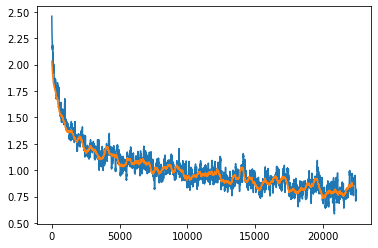

In [25]:
plt.plot(moving_average(cb1.record['loss'],n=40))
plt.plot(moving_average(cb1.record['loss'],n=300))

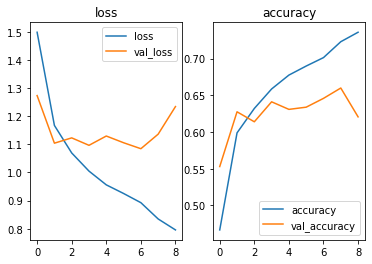

In [24]:
plot_history(hist)

### Attempt 2

In [1]:
BATCH_SIZE = 100
NUM_CLASSES = 100
EPOCHS = 7
INIT_DROPOUT_RATE = 0.5
MOMENTUM_RATE = 0.9
INIT_LEARNING_RATE = 0.01
L2_DECAY_RATE = 0.0005
CROP_SIZE = 32

In [2]:
class FeatureBlock2(tf.keras.Model):

    def __init__(self):
        super(FeatureBlock2, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(96, 
                                           (3,3), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c12  = tf.keras.layers.Conv2D(96, 
                                           (3,3), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m11 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr11 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 2
        self.c21  = tf.keras.layers.Conv2D(96, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c22  = tf.keras.layers.Conv2D(96, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c23  = tf.keras.layers.Conv2D(96, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m21 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr21 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 3
        self.c31  = tf.keras.layers.Conv2D(168, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c32  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c33  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m31 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr31 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
        # Block 4 
        self.c41  = tf.keras.layers.Conv2D(168, 
                                           (1,1), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c42  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.c43  = tf.keras.layers.Conv2D(168, 
                                           (2,2), 
                                           padding='same', 
                                           kernel_regularizer=tf.keras.regularizers.l2(L2_DECAY_RATE), 
                                           activation = tf.keras.activations.elu)
        self.m41 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')
        self.dr41 = tf.keras.layers.Dropout(INIT_DROPOUT_RATE)
        
    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.dr11(x1)
        
        # Block 2
        x2 = self.c21(x1)
        x2 = self.c22(x2)
        x2 = self.c23(x2)
        x2 = self.m21(x2)
        x2 = self.dr21(x2)
        
        # Block 3
        x3 = self.c31(x2)
        x3 = self.c32(x3)
        x3 = self.c33(x3)
        x3 = self.m31(x3)
        x3 = self.dr31(x3)
        
        # Block 4
        x4 = self.c41(x3)
        x4 = self.c42(x4)
        x4 = self.c43(x4)
        x4 = self.m41(x4)
        x4 = self.dr41(x4)
        
        return x4

class DenseBlock2(tf.keras.Model):

    def __init__(self):
        super(DenseBlock2, self).__init__()
        
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(200, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(100, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        x1 = self.f31(inputs)
        x1 = self.d31(x1)
        x1 = self.d32(x1)
        
        return x1

class BasicModel2(tf.keras.Model):

    def __init__(self):
        super(BasicModel2, self).__init__()
        
        self.feature_block = FeatureBlock2()
        self.dense_block = DenseBlock2()

    def call(self, inputs):
        
        x1 = self.feature_block(inputs)
        x2 = self.dense_block(x1)
        
        return x2

NameError: name 'tf' is not defined

In [3]:
model = BasicModel2()
optimizer=tf.keras.optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=MOMENTUM_RATE)
loss=tf.keras.losses.CategoricalCrossentropy()
cb1 = SaveLosseAndMetrics()
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

NameError: name 'BasicModel2' is not defined

In [34]:
hist = model.fit(x_tr, y_tr, epochs= 9
                 , validation_data= (x_te, y_te), callbacks=[cb1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/9
50000/50000 [==============================] - 247s 5ms/sample - loss: 3.2389 - accuracy: 0.2565 - val_loss: 2.9130 - val_accuracy: 0.3193
Epoch 2/9
50000/50000 [==============================] - 254s 5ms/sample - loss: 3.2140 - accuracy: 0.2625 - val_loss: 2.8801 - val_accuracy: 0.3304
Epoch 3/9
50000/50000 [==============================] - 262s 5ms/sample - loss: 3.1987 - accuracy: 0.2672 - val_loss: 2.9286 - val_accuracy: 0.3239
Epoch 4/9
50000/50000 [==============================] - 260s 5ms/sample - loss: 3.1888 - accuracy: 0.2724 - val_loss: 2.9096 - val_accuracy: 0.3270
Epoch 5/9
50000/50000 [==============================] - 274s 5ms/sample - loss: 3.1835 - accuracy: 0.2754 - val_loss: 2.8912 - val_accuracy: 0.3327
Epoch 6/9
50000/50000 [==============================] - 282s 6ms/sample - loss: 3.1801 - accuracy: 0.2750 - val_loss: 2.8381 - val_accuracy: 0.3498
Epoch 7/9
50000/50000 [==============================] -

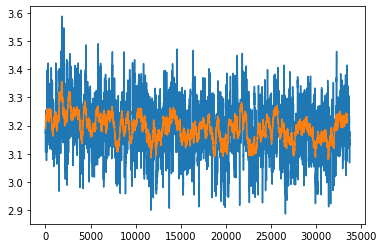

In [37]:
plt.plot(moving_average(cb1.record['loss'],n=40))
plt.plot(moving_average(cb1.record['loss'],n=300))

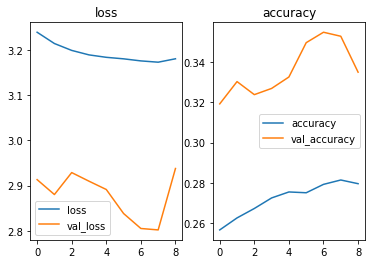

In [38]:
plot_history(hist)